In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as color
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import xarray as xr
from netCDF4 import Dataset
from cmocean import cm
import os
import cv2
from scipy.signal import convolve2d

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
import fnmatch as fn
def find_file_pattern(pattern, path):
    list_file= []
    for file in os.listdir(path):
        if fn.fnmatchcase(file,pattern):
            list_file.append(path+file)
        #print file
    return list_file

In [3]:
import pandas as pd

def date_to_nth_day(date, format='%Y%m%d'):
    date = pd.to_datetime(date, format=format)
    new_year_day = pd.Timestamp(year=date.year, month=1, day=1)
    return (date - new_year_day).days + 1

In [4]:
date_file = 20140605
num_day_of_year= date_to_nth_day(date_file)
print(num_day_of_year)

156


In [5]:
datadir = '/home/cercache/users/cgonzale/data/test/'
graphdir = '/home/cercache/users/cgonzale/snapshots/'
#Parameters that will change to define region and period of interest
Region = 'Mozamb2'
Sensor = 'metop'
year = 2014

In [6]:
folder = datadir+Region+os.sep+Sensor+os.sep+str(year)+os.sep+str(num_day_of_year)

In [7]:
list_file = find_file_pattern('*.nc',folder+os.sep)
print(list_file)

['/home/cercache/users/cgonzale/data/test/Mozamb2/metop/2014/156/20140605185203-OSISAF-L2P_GHRSST-SSTsubskin-AVHRR_SST_METOP_A-sstmgr_metop02_20140605_185203-v02.0-fv01.0.nc', '/home/cercache/users/cgonzale/data/test/Mozamb2/metop/2014/156/20140605184903-OSISAF-L2P_GHRSST-SSTsubskin-AVHRR_SST_METOP_A-sstmgr_metop02_20140605_184903-v02.0-fv01.0.nc', '/home/cercache/users/cgonzale/data/test/Mozamb2/metop/2014/156/20140605062503-OSISAF-L2P_GHRSST-SSTsubskin-AVHRR_SST_METOP_A-sstmgr_metop02_20140605_062503-v02.0-fv01.0.nc']


In [8]:
# load NetCDF 
h = xr.open_dataset(list_file[0]) 
h['lon'] = h.lon
print(h)

<xarray.Dataset>
Dimensions:                  (ni: 1251, nj: 1251, time: 1)
Coordinates:
  * time                     (time) datetime64[ns] 2014-06-05T18:52:03
    lat                      (nj) float32 ...
    lon                      (ni) float32 ...
Dimensions without coordinates: ni, nj
Data variables:
    quality_level            (time, nj, ni) float64 ...
    sea_surface_temperature  (time, nj, ni) float64 ...
    sst_dtime                (time, nj, ni) timedelta64[ns] ...
    satellite_zenith_angle   (time, nj, ni) float64 ...
    sses_bias                (time, nj, ni) float64 ...
    sses_standard_deviation  (time, nj, ni) float64 ...


In [9]:

h.set_coords(['lon','lat'], inplace=True)
toplt = h['sea_surface_temperature'].isel(time=0)-273.15#convert to degrees
print(toplt)

<xarray.DataArray 'sea_surface_temperature' (nj: 1251, ni: 1251)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    time     datetime64[ns] 2014-06-05T18:52:03
    lat      (nj) float32 ...
    lon      (ni) float32 ...
Dimensions without coordinates: nj, ni


In [10]:
print(toplt.shape)

toplt.coords

(1251, 1251)


Coordinates:
    time     datetime64[ns] 2014-06-05T18:52:03
    lat      (nj) float32 ...
    lon      (ni) float32 ...

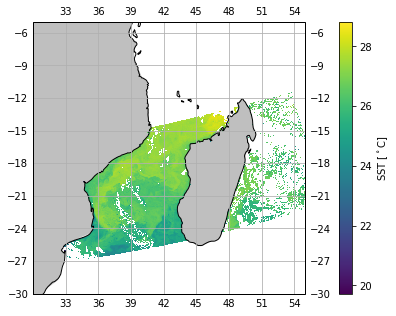

In [11]:
lonmin =toplt.lon.min()
lonmax = toplt.lon.max()
latmin = toplt.lat.min()
latmax = toplt.lat.max()
img_extent = (lonmin, lonmax, latmin, latmax)

fig = plt.figure(figsize=(12, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
cs = ax.imshow(toplt, origin='lower', extent=img_extent, transform=ccrs.PlateCarree())
cbar = fig.colorbar(cs, ax=ax)
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.add_feature(cfeature.LAND, facecolor = '0.75')
ax.gridlines(draw_labels = True)
cbar.set_label('SST [$^\circ$C]')

In [12]:
#select a free cloud area
lonmin_z = 36.
lonmax_z = 37.
latmax_z = -19.
latmin_z = -24.

toplt_zoom = toplt.where(toplt['lon']>=lonmin_z, drop=True)
toplt_zoom = toplt_zoom.where(toplt_zoom['lon']<=lonmax_z, drop=True)
toplt_zoom = toplt_zoom.where(toplt_zoom['lat']<=latmax_z, drop=True)
toplt_zoom = toplt_zoom.where(toplt_zoom['lat']>=latmin_z, drop=True)

print(toplt_zoom)
mask_toplt_zoom = np.isnan(toplt_zoom.values)
print(mask_toplt_zoom.shape)

<xarray.DataArray (nj: 250, ni: 50)>
array([[25.6 , 25.54, 25.46, ..., 26.89, 27.01, 27.07],
       [25.59, 25.55, 25.54, ..., 26.76, 26.98, 27.06],
       [25.49, 25.5 , 25.38, ..., 26.72, 26.85, 27.16],
       ...,
       [26.69, 26.68, 26.69, ..., 26.15, 26.22, 26.17],
       [26.6 , 26.67, 26.69, ..., 26.15, 26.09, 26.05],
       [26.65, 26.78, 26.71, ..., 26.09, 26.08, 25.99]])
Coordinates:
    time     datetime64[ns] 2014-06-05T18:52:03
    lat      (nj) float32 -23.99 -23.97 -23.95 -23.93 -23.91 -23.89 -23.87 ...
    lon      (ni) float32 36.01 36.03 36.05 36.07 36.09 36.11 36.13 36.15 ...
Dimensions without coordinates: nj, ni
(250, 50)


/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


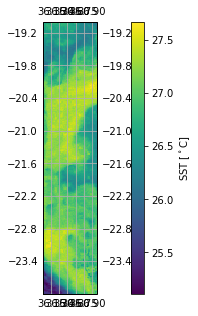

In [13]:
img_extent = (lonmin_z, lonmax_z, latmin_z, latmax_z)

fig = plt.figure(figsize=(12, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
cs = ax.imshow(toplt_zoom, origin='lower', extent=img_extent, transform=ccrs.PlateCarree())
cbar = fig.colorbar(cs, ax=ax)
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.add_feature(cfeature.LAND, facecolor = '0.75')
ax.gridlines(draw_labels = True)
cbar.set_label('SST [$^\circ$C]')

In [14]:
dlon = toplt_zoom['lon'].diff('ni').mean()
dlat = toplt_zoom['lat'].diff('nj').mean()

R_earth = 6378100 #earth radius m
deg2rad = np.pi/180
R_conv = R_earth*deg2rad
print(R_conv)

dy = (dlat*R_conv)
dx = dlon*R_conv*np.cos(deg2rad*toplt_zoom['lat'].mean())

print(dlon, dlat)
print(dx,dy)


111318.84502145034
<xarray.DataArray 'lon' ()>
array(0.02)
Coordinates:
    time     datetime64[ns] 2014-06-05T18:52:03 <xarray.DataArray 'lat' ()>
array(0.02)
Coordinates:
    time     datetime64[ns] 2014-06-05T18:52:03
<xarray.DataArray ()>
array(2071.467354)
Coordinates:
    time     datetime64[ns] 2014-06-05T18:52:03 <xarray.DataArray 'lat' ()>
array(2226.376643)
Coordinates:
    time     datetime64[ns] 2014-06-05T18:52:03


In [15]:
#Compute gradient using numpy
dx = dx.values
dy = dy.values

grad_toplt_y, grad_toplt_x= np.gradient(toplt_zoom, dx, dy)
grad_toplt = np.sqrt(grad_toplt_y**2+grad_toplt_x**2)

In [17]:
#Compute Sobel gradient
sx = np.array([[-1/8,0,1/8],[-1/4,0,1/4],[-1/8,0,1/8]])
sy = np.array([[1/8,1/4,1/8],[0,0,0],[-1/8,-1/4,-1/8]])
sobel_x = convolve2d(toplt_zoom, sx, boundary='symm', mode='same')/dx
sobel_y = convolve2d(toplt_zoom, sy, boundary='symm', mode='same')/dy

sobel_grad = np.sqrt(sobel_x**2+sobel_y**2)


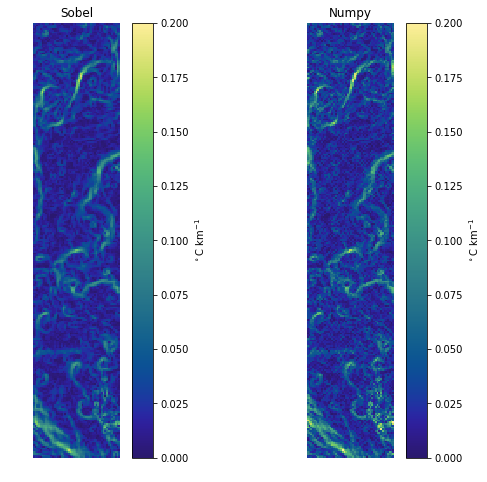

In [25]:
fig, (ax0, ax1) = plt.subplots(ncols=2, nrows=1, figsize=(9, 8))


cs0=ax0.imshow(sobel_grad*1000, cmap=cm.haline,origin = 'lower',vmax=0.2)
_ = ax0.axis('off')
cbar = fig.colorbar(cs0, ax=ax0)
cbar.set_label(r'$^\circ$C km$^{-1}$')
ax0.set_title('Sobel')

cs = ax1.imshow(grad_toplt*1000, origin ='lower', cmap=cm.haline,vmax=0.2)
cbar = fig.colorbar(cs, ax=ax1)
cbar.set_label(r'$^\circ$C km$^{-1}$')
ax1.axis('off')
ax1.set_title('Numpy')
plt.show()

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


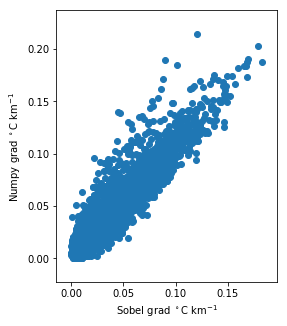

In [29]:
fig = plt.figure(figsize=(12, 5))
plt.scatter(sobel_grad*1000,grad_toplt*1000)
plt.xlabel('Sobel grad $^\circ$C km$^{-1}$')
plt.ylabel('Numpy grad $^\circ$C km$^{-1}$')
plt.axes().set_aspect('equal')